<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 3. Обучение с учителем. Методы классификации
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/TBwVhQ).**

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [2]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [3]:
train_df = pd.read_csv("../../data/titanic_train.csv")
test_df = pd.read_csv("../../data/titanic_test.csv")

In [4]:
y = train_df["Survived"]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Panula, Mr. Jaako Arnold",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
test_df.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Henriksson, Miss. Jenny Lovisa",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [8]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

<AxesSubplot:>

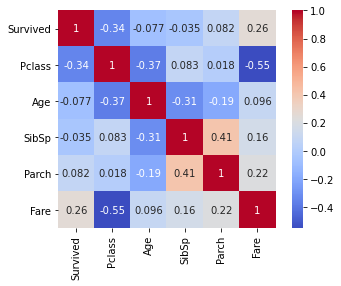

In [9]:
corr_matrix = train_df.drop(['PassengerId'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

**Заполним пропуски медианными значениями.**

In [10]:
def is_baby_name(name):
    if "Master" in name:
        return True
    else:
        return False
test_df[np.isnan(test_df["Age"]) & test_df["Name"].apply(is_baby_name)]
#train_df[np.isnan(train_df["Age"]) & train_df["Name"].apply(is_baby_name)]
#train_df[train_df["Age"]>18]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
244,1136,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
339,1231,3,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C
344,1236,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [11]:
'''
def name_to_age(name):
    if "Master" in name:
        #print(name)
        return 0
    else:
        return 1

#age_categories = [name_to_age(name) for name in train_df.Name]
#train_df[np.isnan(train_df["Age"])]["Age"] = train_df[np.isnan(train_df["Age"])]["Name"].apply(nan_to_age)
#train_df.loc[np.isnan(train_df["Age"]) & ("Master" in train_df["Name"]), 'Age'] = 6
#train_df["Master" in str(train_df["Name"])]["Age"]

train_df["Age_category"] = train_df["Name"].apply(name_to_age)
train_df.loc[np.isnan(train_df["Age"]) & (train_df["Age_category"] == 0), 'Age'] = 6

test_df["Age_category"] = test_df["Name"].apply(name_to_age)
test_df.loc[np.isnan(test_df["Age"]) & (test_df["Age_category"] == 0), 'Age'] = 6
'''
print(
    "Age NaN in train:",
    len(train_df[np.isnan(train_df["Age"])]),
    "Age NaN in test:",
    len(test_df[np.isnan(test_df["Age"])])
)

Age NaN in train: 177 Age NaN in test: 86


In [12]:

train_df["Age"].fillna(train_df["Age"].median(), inplace=True)
test_df["Age"].fillna(train_df["Age"].median(), inplace=True)
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)

'''
train_df["Age"] = train_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
test_df["Age"] = test_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"] = test_df.groupby(['Sex','Pclass'])["Fare"].apply(lambda x: x.fillna(x.median()))
'''

'\ntrain_df["Age"] = train_df.groupby([\'Sex\', \'Pclass\'])[\'Age\'].apply(lambda x: x.fillna(x.median()))\ntest_df["Age"] = test_df.groupby([\'Sex\', \'Pclass\'])[\'Age\'].apply(lambda x: x.fillna(x.median()))\ntrain_df["Embarked"].fillna("S", inplace=True)\ntest_df["Fare"] = test_df.groupby([\'Sex\',\'Pclass\'])["Fare"].apply(lambda x: x.fillna(x.median()))\n'

In [13]:
print(
    "Age NaN in train:",
    len(train_df[np.isnan(train_df["Age"])]),
    "Age NaN in test:",
    len(test_df[np.isnan(test_df["Age"])])
)

Age NaN in train: 0 Age NaN in test: 0


**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [14]:
pd.get_dummies(train_df["Pclass"], prefix="PClass")

,PClass_1,PClass_2,PClass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
886,0,1,0
887,1,0,0
888,0,0,1
889,1,0,0


In [15]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["Pclass"], prefix="PClass"),
        pd.get_dummies(train_df["Sex"], prefix="Sex"),
        pd.get_dummies(train_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(train_df["Parch"], prefix="Parch"),
        pd.get_dummies(train_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)
test_df = pd.concat(
    [
        test_df,
        pd.get_dummies(test_df["Pclass"], prefix="PClass"),
        pd.get_dummies(test_df["Sex"], prefix="Sex"),
        pd.get_dummies(test_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(test_df["Parch"], prefix="Parch"),
        pd.get_dummies(test_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,0,0,0,0,0,0,0,1


In [17]:
train_df.drop(
    [
        "Survived",
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
        #"Age_category",
    ],
    axis=1,
    inplace=True,
)
test_df.drop(
    [
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
        #"Age_category",
    ],
    axis=1,
    inplace=True,
)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [18]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [19]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [20]:
test_df.drop(["Parch_9"], axis=1, inplace=True)

In [21]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [22]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [23]:
# Ваш код здесь
tree = DecisionTreeClassifier(max_depth=2, random_state=17)
tree.fit(train_df, y)

DecisionTreeClassifier(max_depth=2, random_state=17)

In [24]:
test_df.columns

Index(['Age', 'Fare', 'PClass_1', 'PClass_2', 'PClass_3', 'Sex_female',
       'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [25]:
# Ваш код здесь
tree_pred = tree.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [26]:
# Ваш код здесь
len(tree_pred)
write_to_submission_file(
    tree_pred,
    "titanic_predict_untuned_tree_3.csv",
    train_num=891,
    target="Survived",
    index_label="PassengerId",
)

<font color='red'>Вопрос 1. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?
- 0.746
- 0.756
- 0.766
- 0.776

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

In [27]:
# Ваш код здесь
from io import StringIO

import pydotplus

# используем .dot формат для визуализации дерева
from ipywidgets import Image

dot_data = StringIO()
export_graphviz(tree, feature_names=test_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x89\x00\x00\x01g\x08\x06\x00\x00\x00\xcaq\xd3N\x…

<font color='red'>Вопрос 2. </font> Сколько признаков задействуются при прогнозе деревом решений глубины 2?
- 2
- 3
- 4
- 5

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [28]:
# tree params for grid search
tree_params = {"max_depth": list(range(1, 5)), "min_samples_leaf": list(range(1, 5))}

# Ваш код здесь
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(train_df, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4]},
             verbose=True)

In [29]:
tree_grid.best_params_

{'max_depth': 3, 'min_samples_leaf': 3}

<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?
- max_depth=2, min_samples_leaf=1
- max_depth=2, min_samples_leaf=4
- max_depth=3, min_samples_leaf=2
- max_depth=3, min_samples_leaf=3

In [30]:
tree_grid.best_score_

0.8103132257862031

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?
- 0.77
- 0.79
- 0.81
- 0.83

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [31]:
# Ваш код здесь
treeg_pred = tree_grid.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle.**

In [32]:
# Ваш код здесь
write_to_submission_file(
    treeg_pred,
    "titanic_predict_tuned_tree_4.csv",
    train_num=891,
    target="Survived",
    index_label="PassengerId",
)
# 0.77751

<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?
- 0.7499
- 0.7599
- 0.7699
- 0.7799

In [33]:
treet = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=17)
treet.fit(train_df, y)
treet_pred = treet.predict(test_df)
write_to_submission_file(
    treet_pred,
    "titanic_predict_tuned_tree_5.csv",
    train_num=891,
    target="Survived",
    index_label="PassengerId",
)
# 0.77751

In [34]:
from io import StringIO

import pydotplus

# используем .dot формат для визуализации дерева
from ipywidgets import Image

dot_data = StringIO()
export_graphviz(treet, feature_names=test_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xe1\x00\x00\x01\xf1\x08\x06\x00\x00\x00+\xcb\xa8…

In [35]:
# let's try forest
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, train_df, y, cv=5)))

0.8013935095097608


In [36]:
forest_params = {"max_depth": range(1, 15), "max_features": range(2, 20)}
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(train_df, y)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:   16.3s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'max_features': range(2, 20)},
             verbose=True)

In [37]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 10, 'max_features': 12}, 0.8361684765551441)

In [38]:
forest_pred = forest_grid.predict(test_df)
write_to_submission_file(
    forest_pred,
    "titanic_predict_tuned_forest_6.csv",
    train_num=891,
    target="Survived",
    index_label="PassengerId",
)
# 0.77511

## Ссылки:

 - <a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster"
 - <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"